# Extra Notebook 1. Literature Review

This Notebook contains code samples used to generate results in the [Literature Review Chapter](../Chapters/02.LiteratureReview.ipynb)

In [26]:
%run ../Config/ConfigImports.ipynb

## Decision Trees

Here is an example of a simple Decision Tree with maximum depth set to only $3$ levels and minimum samples required to split a node set to $7$. This is done for the readability and ilustrative purposes only, usually deeper trees are used.

In [6]:
# read in dataset with object counts and weather data
merged = pd.read_csv('../Datasets/merged.csv')

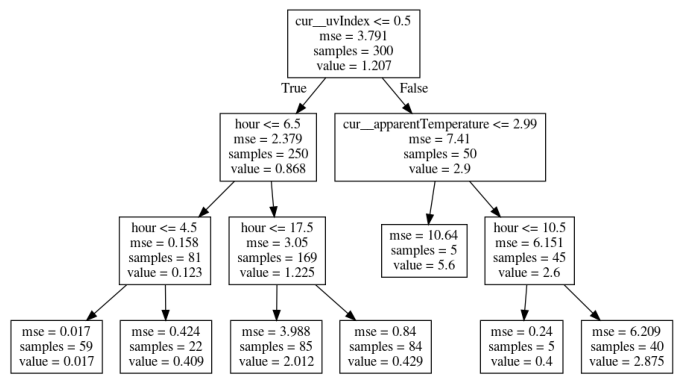

In [7]:
# render a decision tree
from sklearn import tree
from sklearn.tree import export_graphviz

use_cols = ['hour', 'n_month', 'day_of_week', 'is_weekend_day', 'cur__precipIntensity',
    'cur__precipProbability', 'cur__apparentTemperature', 'cur__humidity', 'cur__windSpeed',
    'cur__uvIndex']
tree_dataset = merged[use_cols + ['obs_count']].sample(300, random_state=CONFIG['RANDOM_STATE'])

model = tree.DecisionTreeRegressor(random_state=CONFIG['RANDOM_STATE'], max_depth=3, min_samples_split=7)
model = model.fit(tree_dataset.drop(columns=['obs_count']), tree_dataset['obs_count'])

export_graphviz(model, '../Resources/img/tree.dot', feature_names=tree_dataset.drop(columns=['obs_count']).columns)
!dot -Tpng ../Resources/img/tree.dot -o ../Resources/img/tree.png

img = cv2.imread('../Resources/img/tree.png')
plt.figure(figsize = (12, 12))
plt.axis('off')
plt.imshow(img);

## Gaussian Process

**Univariate Gaussian:**

In [8]:
def uni_normal(x, mean, sigma):
    """Use equation above to generate probability for points above"""
    return 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-(x-mean)**2/(2*sigma**2))

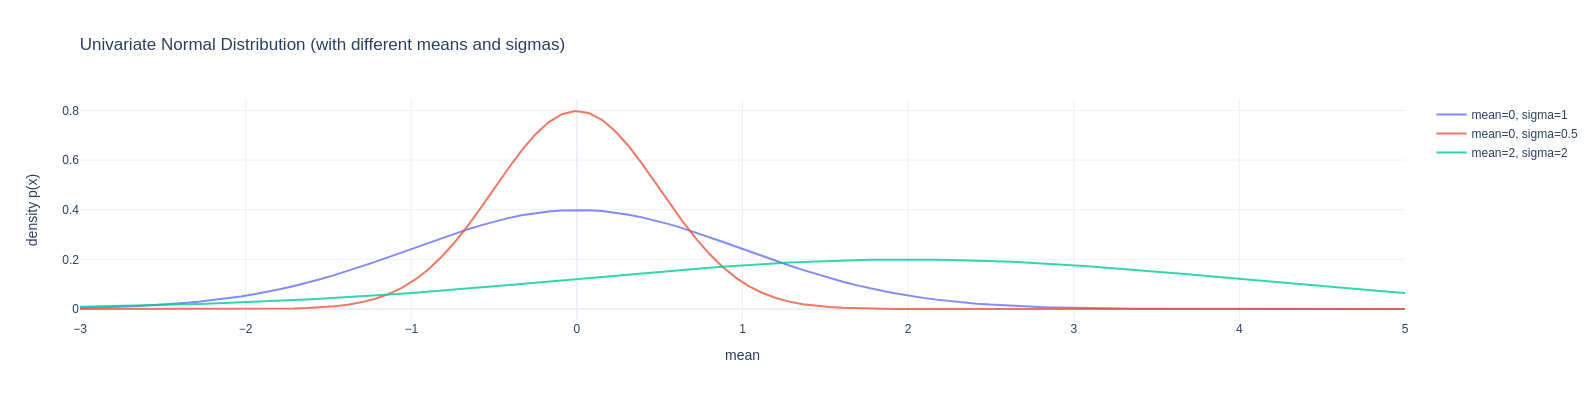

In [10]:
# use Gaussian to generate probabilities for a set of points
x = np.linspace(-3, 5, 100)
y1 = uni_normal(x, 0, 1)
y2 = uni_normal(x, 0, 0.5)
y3 = uni_normal(x, 2, 2)

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y1, mode='lines', name='mean=0, sigma=1', opacity=0.8))
fig.add_trace(go.Scatter(x=x, y=y2, mode='lines', name='mean=0, sigma=0.5', opacity=0.8))
fig.add_trace(go.Scatter(x=x, y=y3, mode='lines', name='mean=2, sigma=2', opacity=0.8))
fig.update_layout(autosize=False, width=650, height=400,
    xaxis_title="mean", yaxis_title="density p(x)",
    title='Univariate Normal Distribution (with different means and sigmas)')
fig.show()

**Multivariate Gaussian:**

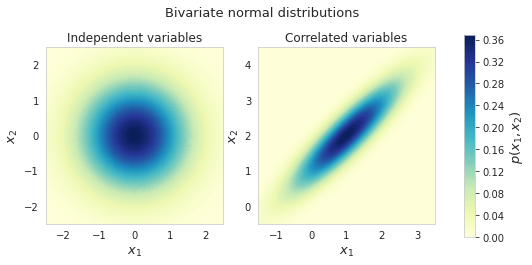

In [11]:
def multi_normal(x, d, mean, covariance):
    """pdf of the multivariate normal distribution."""
    x_m = x - mean
    return (1. / (np.sqrt((2 * np.pi)**d * np.linalg.det(covariance))) * 
            np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m)) / 2))

# Plot bivariate distribution
def generate_surface(mean, covariance, d):
    """Helper function to generate density surface."""
    nb_of_x = 100 # grid size
    x1s = np.linspace(-5, 5, num=nb_of_x)
    x2s = np.linspace(-5, 5, num=nb_of_x)
    x1, x2 = np.meshgrid(x1s, x2s) # Generate grid
    pdf = np.zeros((nb_of_x, nb_of_x))
    # Fill the cost matrix for each combination of weights
    for i in range(nb_of_x):
        for j in range(nb_of_x):
            pdf[i,j] = multi_normal(np.matrix([[x1[i,j]], [x2[i,j]]]), d, mean, covariance)
    return x1, x2, pdf

# Import colormaps
from matplotlib import cm

# subplot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
d = 2  # number of dimensions

# Plot of independent Normals
bivariate_mean = np.matrix([[0.], [0.]])  # Mean
bivariate_covariance = np.matrix([
    [1., 0.], 
    [0., 1.]])  # Covariance
x1, x2, p = generate_surface(
    bivariate_mean, bivariate_covariance, d)
# Plot bivariate distribution
con = ax1.contourf(x1, x2, p, 100, cmap=cm.YlGnBu)
ax1.set_xlabel('$x_1$', fontsize=13)
ax1.set_ylabel('$x_2$', fontsize=13)
ax1.axis([-2.5, 2.5, -2.5, 2.5])
ax1.set_aspect('equal')
ax1.set_title('Independent variables', fontsize=12)

# Plot of correlated Normals
bivariate_mean = np.matrix([[1.], [2.]])  # Mean
bivariate_covariance = np.matrix([
    [1., 0.9], 
    [0.9, 1.]])  # Covariance
x1, x2, p = generate_surface(
    bivariate_mean, bivariate_covariance, d)
# Plot bivariate distribution
con = ax2.contourf(x1, x2, p, 100, cmap=cm.YlGnBu)
ax2.set_xlabel('$x_1$', fontsize=13)
ax2.set_ylabel('$x_2$', fontsize=13)
ax2.axis([-1.5, 3.5, -0.5, 4.5])
ax2.set_aspect('equal')
ax2.set_title('Correlated variables', fontsize=12)

# Add colorbar and title
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(con, cax=cbar_ax)
cbar.ax.set_ylabel('$p(x_1, x_2)$', fontsize=13)
plt.suptitle('Bivariate normal distributions', fontsize=13, y=0.95)
plt.show()

**Sampling from Multivariate Gaussian:**

<a id="sample-corr"></a>

In [21]:
mean, covariance = np.matrix([[1.], [2.]]), np.matrix([[1, 0.8], [0.8, 1]]) # Define mean and covariance
L = np.linalg.cholesky(covariance) # Apply Cholesky to find L
X = np.random.normal(size=(2, 50)) # Sample X from standard normal
Y = L.dot(X) + mean # Apply the transformation
print(Y[:2,:5]) # Show sample 2 records, 5 columns

[[ 1.41369215 -0.62904024  1.55960674  2.82077579  0.58977816]
 [ 2.32505486 -0.02885016  1.87705227  3.58002911  1.61636364]]


- Calculate $x|y$:

```python
y_condition = 1.  # To condition on y
mean_xgiveny = mean_x + (C * (1/B) * (y_condition - mean_y))
cov_xgiveny = A - C * (1/B) * C
```

- Calculate $y|x$

```python
x_condition = -1.  # To condition on x
mean_ygivenx = mean_y + (C * (1/A) * (x_condition - mean_x))
cov_ygivenx = B - (C * (1/A) * C)
```

**Sampling from BRF Kernel:**

In [23]:
from scipy.spatial.distance import cdist
# Define the exponentiated quadratic 
def exponentiated_quadratic(xa, xb):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

In [24]:
# Sample from the Gaussian process distribution
nb_of_samples = 150  # Number of points in each function
number_of_functions = 5  # Number of functions to sample
# Independent variable samples
X = np.expand_dims(np.linspace(-4, 4, nb_of_samples), 1)
kernel = exponentiated_quadratic(X, X)  # Kernel of data points

# Draw samples from the prior at our data points.
# Assume a mean of 0 for simplicity
ys = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=kernel, 
    size=number_of_functions)

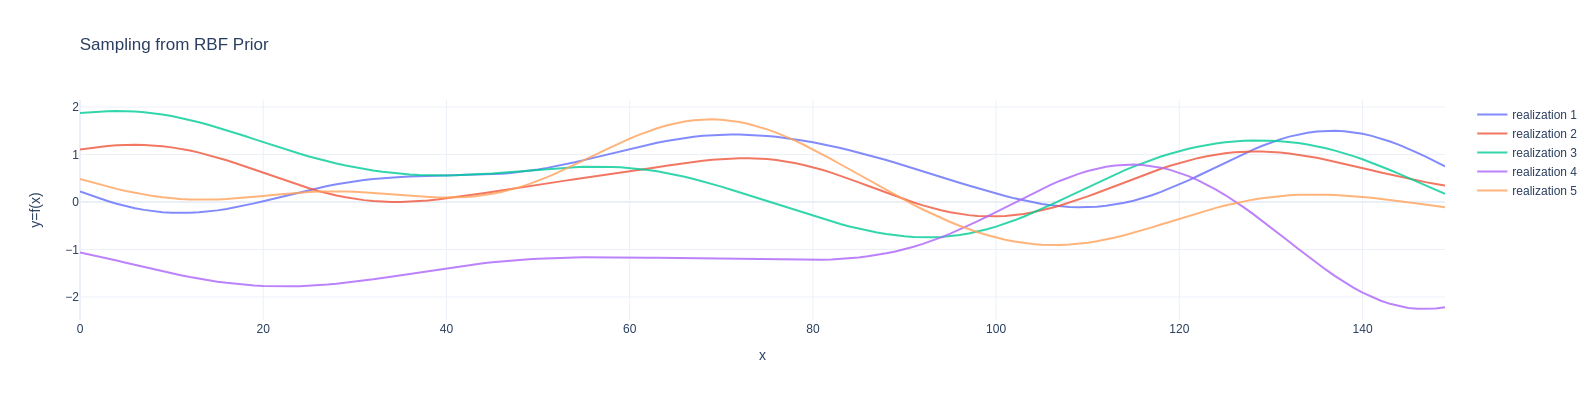

In [25]:
fig = go.Figure()
for i,y in enumerate(ys):
    fig.add_trace(go.Scatter(y=y, mode='lines', name=f'realization {i+1}', opacity=0.8))
fig.update_layout(autosize=False, width=650, height=400,
    xaxis_title="x", yaxis_title="y=f(x)", title='Sampling from RBF Prior')
fig.show()